In [18]:
import cv2
import os
import numpy as np
from utils import show_images

# shape 模块 可以分类如下
# class  	cv::ShapeTransformer
    # class  	cv::AffineTransformer
    # class  	cv::ThinPlateSplineShapeTransformer
 
# class  	cv::HistogramCostExtractor
    # class  	cv::ChiHistogramCostExtractor
    # class  	cv::EMDHistogramCostExtractor
    # class  	cv::EMDL1HistogramCostExtractor
    # class  	cv::NormHistogramCostExtractor
 
# class  	cv::ShapeDistanceExtractor
    # class  	cv::HausdorffDistanceExtractor
    # class  	cv::ShapeContextDistanceExtractor

def draw_points(srcimg, points):
    result = np.zeros((srcimg.shape[0], srcimg.shape[1], 3))
    ps = points.reshape(-1, 2)
    for p in ps:
        p0, p1 = int(p[0]), int(p[1])
        result[p1-2:p1+3, p0-2:p0+3] = [0, 255, 0]
    return result.astype(np.uint8)

# **一个**轮廓 -> float32 的 points
def make_points(contour, n=None):
    points = contour.reshape(-1, 1, 2)

    # 本来到这里就结束了，不过 OpenCV 给的示例代码有下面类似的实现
    # 不是很清楚目的，估计为了加快速度，相当于重采样，在 contour 上选择 n 个点
    # 但是实际使用我感觉好影响准确率，n 的值不好把握，对于大的轮廓要大，但多大不好确定
    if n is not None:
        np.random.shuffle(points) # 先打乱这些点
        if points.shape[0] < n:
            new_array = np.pad(points, ((0, n-points.shape[0]), (0, 0), (0, 0)), 'edge')
            points = new_array
        else:
            points = points[:n]

    return points.astype(np.float32)


0.6541350170764999
0.6541350170764999
0.6541350170764999
0.6541350170764999


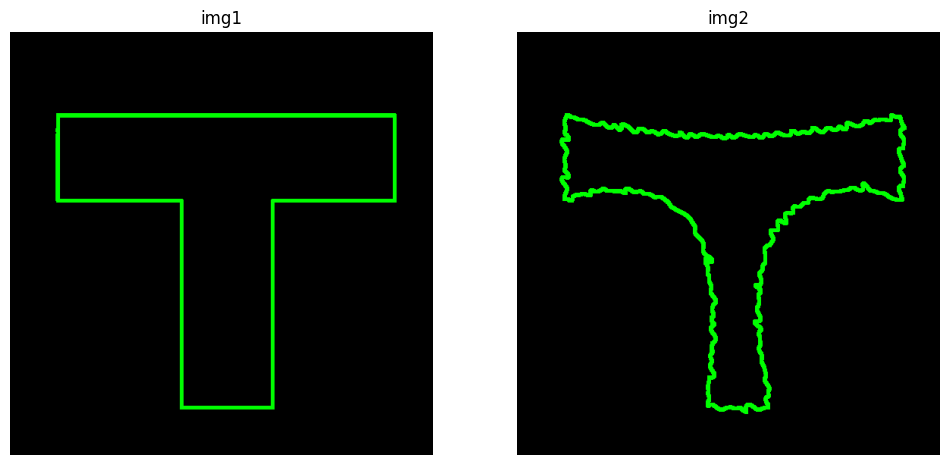

In [19]:
'''
测试 matchShapes
'''
img1 = cv2.imread('./image/shape/13.png', -1)
contours1, _ = cv2.findContours(img1, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
points1 = make_points(contours1[0])

img2 = cv2.imread('./image/shape/14.png', -1)
contours2, _ = cv2.findContours(img2, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
points2 = make_points(contours2[0])

print(cv2.matchShapes(points1.reshape((-1, 1, 2)), points2.reshape((-1, 1, 2)), 1, 0))
print(cv2.matchShapes(points1.astype(int), points2.astype(int), 1, 0))
print(cv2.matchShapes(points1.reshape((1, -1, 2)), points2.reshape((1, -1, 2)), 1, 0))
print(cv2.matchShapes(contours1[0], contours2[0], 1, 0))

show_images([
    ('img1', draw_points(img1, points1)),
    ('img2', draw_points(img2, points2)),
])


In [20]:
'''
Shape Distance Extractor 使用说明
'''
# class  	cv::ShapeDistanceExtractor -> computeDistance
    # class  	cv::HausdorffDistanceExtractor
    # class  	cv::ShapeContextDistanceExtractor
extractor = cv2.createShapeContextDistanceExtractor()

src = cv2.imread('./image/shape/13.png', -1)
src_contours, _ = cv2.findContours(src, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
src_points = make_points(src_contours[0], n=500)

for imgname in os.listdir('./image/shape'):
    now = cv2.imread(f'./image/shape/{imgname}', -1)
    now_contours, _ = cv2.findContours(now, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    now_points = make_points(now_contours[0], n=500)

    # 传入的必须是 (x, 1, 2) 或 (1, x, 2) 这种 shape 的 ndarray，两个 ndarray 的 x 不强制要一样
    result1 = extractor.computeDistance(src_points.reshape(1, -1, 2), now_points.reshape(1, -1, 2))
    result2 = extractor.computeDistance(src_points.reshape(-1, 1, 2), now_points.reshape(-1, 1, 2))
    print(imgname, result1, result2)
    break

1.png 7.284451007843018 7.284451007843018


In [21]:
'''
HistogramCostExtractor 使用说明
'''
# class  	cv::HistogramCostExtractor -> buildCostMatrix
    # class  	cv::ChiHistogramCostExtractor
    # class  	cv::EMDHistogramCostExtractor
    # class  	cv::EMDL1HistogramCostExtractor
    # class  	cv::NormHistogramCostExtractor
extractor = cv2.createChiHistogramCostExtractor()

src = cv2.imread('./image/shape/13.png', -1)
src_contours, _ = cv2.findContours(src, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
src_points = make_points(src_contours[0])

for imgname in os.listdir('./image/shape'):
    now = cv2.imread(f'./image/shape/{imgname}', -1)
    now_contours, _ = cv2.findContours(now, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    now_points = make_points(now_contours[0])

    result = extractor.buildCostMatrix(src_points, now_points)
    print(imgname)
    print(src_points.shape, now_points.shape)
    print(result.shape)
    break

1.png
(1657, 1, 2) (590, 1, 2)
(1682, 1682)


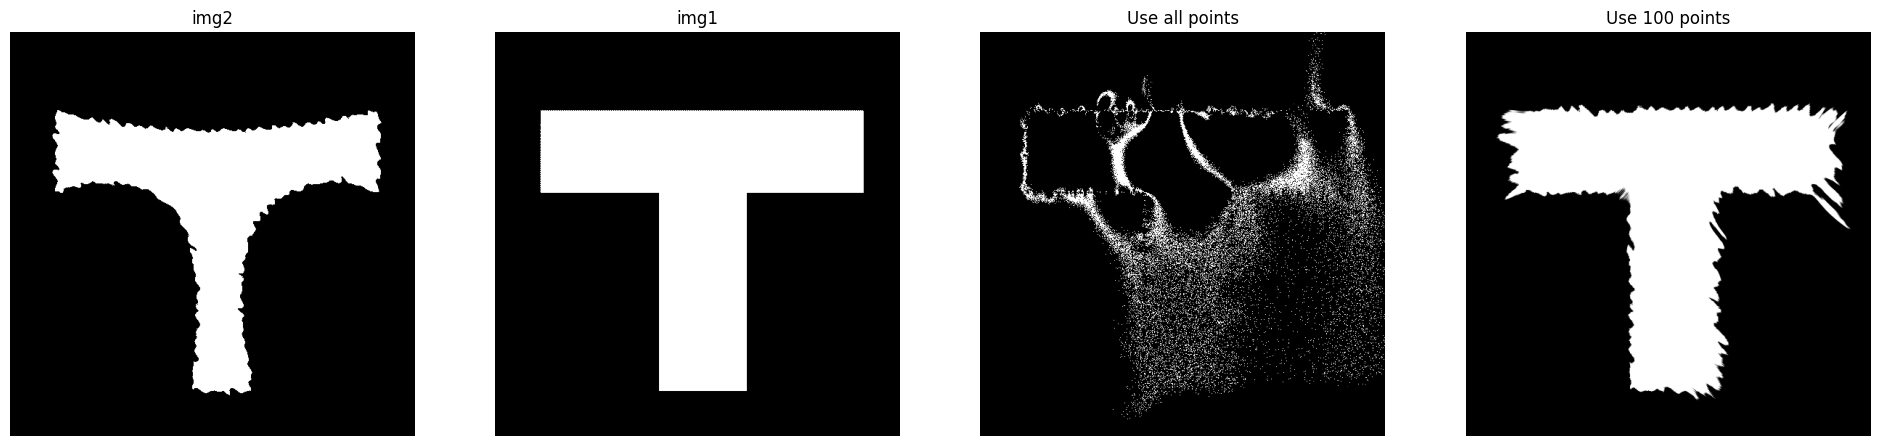

In [22]:
'''
ShapeTransformer 单独使用
'''
img1 = cv2.imread('./image/shape/13.png', -1)
contours1, _ = cv2.findContours(img1, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
points1 = make_points(contours1[0])

img2 = cv2.imread('./image/shape/14.png', -1)
contours2, _ = cv2.findContours(img2, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
points2 = make_points(contours2[0])

transformer = cv2.createThinPlateSplineShapeTransformer()

# 所有点都考虑，并不一定是好事情
matches = [cv2.DMatch(i, i, 0) for i in range(points1.shape[0])]
transformer.estimateTransformation(points1.reshape(1, -1, 2), points2.reshape(1, -1, 2), matches)
img3 = transformer.warpImage(img2)

# 采样点，采大约 100 个点
points1 = points1[::points1.shape[0]//100]
points2 = points2[::points2.shape[0]//100]
matches = [cv2.DMatch(i, i, 0) for i in range(points1.shape[0])]
transformer.estimateTransformation(points1.reshape(1, -1, 2), points2.reshape(1, -1, 2), matches)
img4 = transformer.warpImage(img2)

show_images([
    ('img2', img2),
    ('img1', img1),
    ('Use all points', img3),
    ('Use 100 points', img4)
])